In [13]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from keras import layers, models, optimizers, callbacks, regularizers
from sklearn.utils.class_weight import compute_class_weight
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

### Preprocesamiento

In [3]:
df_train = pd.read_parquet('data/data_train.parquet')
df_test = pd.read_parquet('data/data_test.parquet')
df_train

,polarity,title,text
0,2,"Finally a Decent Metallica, Welcome Back Guys!!","Being a metal head from the early early 80's, ..."
1,2,There's so much Van it's easy to get lost,To anybody not familiar with Van's non-radio r...
2,1,Does not teach the TM Technique!!!,For the past few months i have been doing medi...
3,1,Horrible,This is a truly terrible book. Even though it ...
4,2,Best pregnancy purchase yet!,I love this pillow and can't imagine pregnancy...
...,...,...,...
299995,1,"OKAY, The Joke Is Over!",WOW! This collection sure SUCKS!As Simon Cowel...
299996,2,A rip-roaring adventure,I knew this was a good book before I read it. ...
299997,2,Romantic Melodies,I love all aspects of the beauty of the instru...
299998,1,Very Disappointed,I was very disappointed by these headphones. T...


In [4]:
## cambiamos la etiqueta a binario, 1 == positivo, 0== negativo
##polarity - 1 for negative and 2 for positive
df_train['target'] = np.where(df_train['polarity']==2,1,0)
df_test['target'] = np.where(df_test['polarity']==2,1,0)

In [17]:
model = SentenceTransformer('all-MiniLM-L6-v2')
model

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [18]:
sentences = ["Esta es una oración de ejemplo.", "Cada oración se convierte en un embedding."]
embeddings = model.encode(sentences)
embeddings

array([[ 3.79728503e-03,  1.04717784e-01,  9.60196462e-03,
        -2.17039865e-02, -3.97481099e-02,  3.02937720e-02,
         4.97237146e-02, -3.37745529e-03,  1.96438506e-02,
         5.33707775e-02,  5.29258847e-02, -3.47857028e-02,
        -5.02440408e-02, -2.87015140e-02,  8.50886032e-02,
         4.26170081e-02,  1.15045644e-02,  4.70031761e-02,
         6.65140375e-02,  4.42016982e-02,  9.27361026e-02,
        -5.69660701e-02, -3.50026116e-02,  6.03753030e-02,
        -8.96932036e-02,  2.38370579e-02, -1.47844013e-02,
         6.01354539e-02, -6.32659644e-02, -1.04838967e-01,
         8.35220329e-03, -1.94905587e-02,  3.71338464e-02,
        -1.27224736e-02,  4.73072380e-03, -4.29892838e-02,
         6.07287437e-02, -5.49539104e-02, -7.46254921e-02,
         7.12293014e-02, -1.49797902e-01, -4.92797792e-02,
        -1.06316455e-01,  7.27618113e-03, -1.86708272e-02,
        -9.81037989e-02, -1.19596720e-02,  8.26072916e-02,
         4.95551601e-02, -3.69458273e-02,  1.73226558e-0

In [25]:
df_train['embeddings_title'] = df_train['title'].apply(
    lambda x: model.encode(x) if x is not None else None
)
df_train

,polarity,title,text,target,embeddings_title
0,2,"Finally a Decent Metallica, Welcome Back Guys!!","Being a metal head from the early early 80's, ...",1,"[0.021670403, -0.022296194, 0.04540264, 0.0111..."
1,2,There's so much Van it's easy to get lost,To anybody not familiar with Van's non-radio r...,1,"[0.071497686, 0.0015414994, 0.058490727, 0.001..."
2,1,Does not teach the TM Technique!!!,For the past few months i have been doing medi...,0,"[0.07062342, 0.014294546, 0.0023847024, -0.067..."
3,1,Horrible,This is a truly terrible book. Even though it ...,0,"[-0.024966478, 0.032874458, -0.04621502, -0.00..."
4,2,Best pregnancy purchase yet!,I love this pillow and can't imagine pregnancy...,1,"[-0.099332616, -0.011706109, 0.009174509, 0.02..."
...,...,...,...,...,...
299995,1,"OKAY, The Joke Is Over!",WOW! This collection sure SUCKS!As Simon Cowel...,0,"[-0.029559448, -0.07018569, -0.0025222756, 0.0..."
299996,2,A rip-roaring adventure,I knew this was a good book before I read it. ...,1,"[-0.061920587, 0.05480035, 0.030223211, -0.031..."
299997,2,Romantic Melodies,I love all aspects of the beauty of the instru...,1,"[-0.0079423, -0.043733716, 0.10396589, 0.02088..."
299998,1,Very Disappointed,I was very disappointed by these headphones. T...,0,"[-0.038401086, 0.0050897812, -0.009263077, -0...."


In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   polarity          300000 non-null  int64 
 1   title             299982 non-null  object
 2   text              300000 non-null  object
 3   target            300000 non-null  int64 
 4   embeddings_title  299982 non-null  object
dtypes: int64(2), object(3)
memory usage: 11.4+ MB


In [32]:
df_test['embeddings_title'] = df_test['title'].apply(
    lambda x: model.encode(x) if x is not None else None
)
df_test

,polarity,title,text,target,embeddings_title
0,2,Get out of the Ratrace!,1985 was the year I realised that the New Wave...,1,"[-0.005234256, 0.03550048, -0.035583626, -0.00..."
1,2,rain gauge,This was the second rain gauge I had purchased...,1,"[-0.069723874, 0.053811196, 0.035691544, 0.035..."
2,2,6 Minute Solutions BETTER than 246 Solved SE P...,I was pleasantly surprised by the time taken w...,1,"[-0.05012186, 0.06121789, 0.048590984, -0.0780..."
3,2,quite good,works finesound is good. not wery loud but cla...,1,"[-0.0970042, 0.0033232195, -0.035562973, -0.02..."
4,1,Not worth the total price including shipping,You might find the same product locally in som...,0,"[-0.05943303, 0.026308957, 0.02310065, -0.0128..."
...,...,...,...,...,...
79995,2,Great for several reasons,"I bought this for my standard poodle, but it w...",1,"[0.002992782, -0.01498702, -0.0039905366, -0.0..."
79996,2,Bobby goes TOTO,Bobby Kimball has finally made the record we w...,1,"[-0.04958881, 0.020358965, -0.1336912, -0.0204..."
79997,1,Young Buck Your So Awesome,Yes!!! One of my favorite cd's to take a nice ...,0,"[-0.034167003, 0.011988885, 0.019295555, -0.02..."
79998,1,Don't judge a book by it's cover,Don't fall for the idea of this book. It's a g...,0,"[0.0010853346, 0.0779123, -0.003220714, 0.0321..."


In [34]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   polarity          80000 non-null  int64 
 1   title             79998 non-null  object
 2   text              80000 non-null  object
 3   target            80000 non-null  int64 
 4   embeddings_title  79998 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.1+ MB


### train model

In [35]:
#modelo
model = models.Sequential()
model.add(layers.Input(shape=(384,)))
model.add(layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

#early stopping
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

In [41]:
X_train = np.stack(df_train["embeddings_title"].values)
y_train = df_train["target"].values
X_test = np.stack(df_test["embeddings_title"].values)
y_test = df_test["target"].values

In [42]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=256,
    callbacks=[early_stopping]
)

Epoch 1/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.7379 - loss: 0.7741 - val_accuracy: 0.8238 - val_loss: 0.4874
Epoch 2/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8228 - loss: 0.4752 - val_accuracy: 0.8260 - val_loss: 0.4350
Epoch 3/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.8245 - loss: 0.4329 - val_accuracy: 0.8273 - val_loss: 0.4141
Epoch 4/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8257 - loss: 0.4147 - val_accuracy: 0.8283 - val_loss: 0.4033
Epoch 5/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8282 - loss: 0.4032 - val_accuracy: 0.8296 - val_loss: 0.3966
Epoch 6/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8283 - loss: 0.3981 - val_accuracy: 0.8311 - val_loss: 0.3921
Epoch 7/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8309 - loss: 0.3915 - val_accuracy: 0.8323 - val_loss: 0.3887
Epoch 8/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.8312 - 

### test model

In [4]:
import pandas as pd
from utils_test import *

In [44]:
df_test["pred_model"] = model.predict(np.stack(df_test["embeddings_title"].values))
df_test["pred_model"].describe()

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


,pred_model
count,79998.000000
mean,0.500634
std,0.375967
min,0.000493
25%,0.091556
50%,0.519471
75%,0.901692
max,0.999510


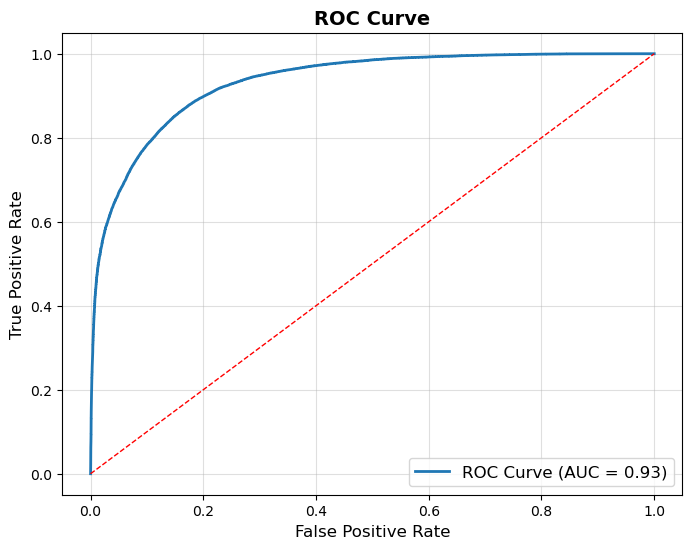

In [5]:
plot_roc_auc(df_test["pred_model"], df_test["target"])

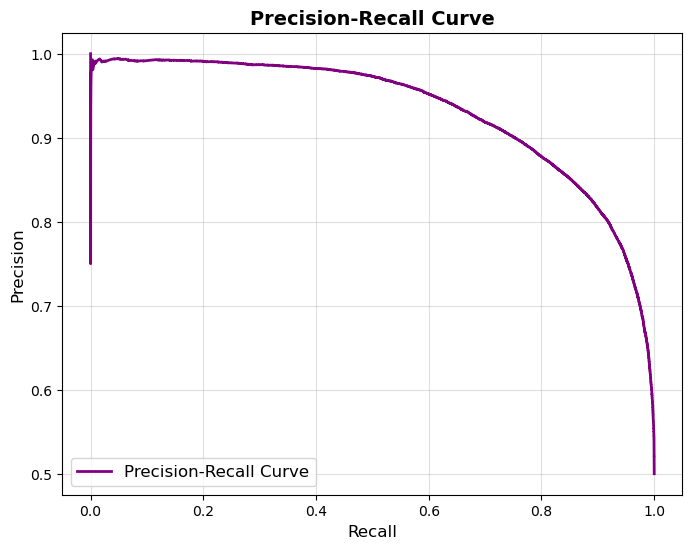

In [6]:
plot_precision_recall_curve(df_test["pred_model"], df_test["target"])

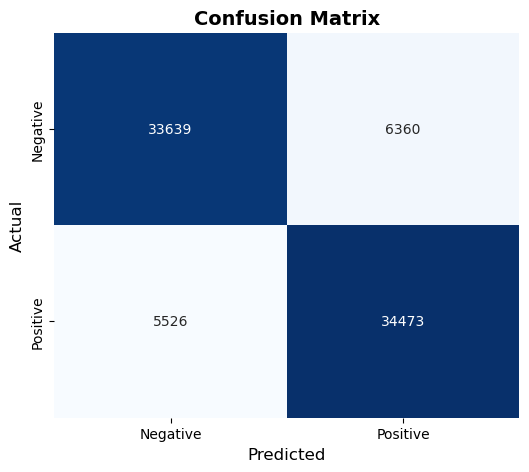

Classification Metrics:

              precision    recall  f1-score   support

    Negative       0.86      0.84      0.85     39999
    Positive       0.84      0.86      0.85     39999

    accuracy                           0.85     79998
   macro avg       0.85      0.85      0.85     79998
weighted avg       0.85      0.85      0.85     79998

Accuracy: 0.85


In [7]:
plot_confusion_matrix_and_metrics(df_test["pred_model"], df_test["target"], threshold=0.5)